In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from scipy.misc import imread, imresize
from PIL import Image

import cv2
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading the Model

In [59]:
model='ckpt.pth'
file_path='mirror.png' 
img = None
word_map='wordmap.json'
beam_size=5
smooth=False

# Load model
checkpoint = torch.load(model, map_location=str(device))
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()

encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(word_map, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

print('Model Loaded','# '*40)

C:\Users\Vinay\miniconda3\envs\torch\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'models.Encoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Vinay\miniconda3\envs\torch\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Users\Vinay\miniconda3\envs\torch\lib\site-packages\torch\serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the obj

Model Loaded # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 


Here the encoder and decoder model is loaded 

- encoder model is ResNet101 pretrained on imagenet
- decoder model is LSTM Recurrent Neural Net

In [31]:
# torch.torchsummary
print(encoder)

Encoder(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [38]:
# !pip install torchsummary
from torchsummary import summary

summary(encoder,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [44]:
# summary(decoder, (2048,14,14))

In [40]:
print(decoder)

DecoderWithAttention(
  (attention): Attention(
    (encoder_att): Linear(in_features=2048, out_features=512, bias=True)
    (decoder_att): Linear(in_features=512, out_features=512, bias=True)
    (full_att): Linear(in_features=512, out_features=1, bias=True)
    (relu): ReLU()
    (softmax): Softmax(dim=1)
  )
  (embedding): Embedding(9490, 512)
  (dropout): Dropout(p=0.5, inplace=False)
  (decode_step): LSTMCell(2560, 512, bias=1)
  (init_h): Linear(in_features=2048, out_features=512, bias=True)
  (init_c): Linear(in_features=2048, out_features=512, bias=True)
  (f_beta): Linear(in_features=512, out_features=2048, bias=True)
  (sigmoid): Sigmoid()
  (fc): Linear(in_features=512, out_features=9490, bias=True)
)


## Loading The Image - Normalising it as per ImageNet

In [58]:
# Read image and process
# img = Image.open(image_path).convert('RGB')
# ISSUE OF ALPHA CHANNEL IN 4D IMAGE - CONVERTED TO 3D
if img is None:
    if file_path is not None:
        img = cv2.imread(file_path)
        orig_frame=img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

if len(img.shape) == 2:
    img = img[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)

img = imresize(img, (256, 256))
img = img.transpose(2, 0, 1)
img = img / 255.
img = torch.FloatTensor(img).to(device)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
transform = transforms.Compose([normalize])
image = transform(img)  # (3, 256, 256)

TypeError: Expected Ptr<cv::UMat> for argument 'src'

In [27]:
"""
Reads an image and captions it with beam search.

:param encoder: encoder model
:param decoder: decoder model
:param image_path: path to image
:param word_map: word map
:param beam_size: number of sequences to consider at each decode-step
:return: caption, weights for visualization
"""

k = beam_size
vocab_size = len(word_map)

# Encode
image = image.unsqueeze(0)  # (1, 3, 256, 256)
encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
enc_image_size = encoder_out.size(1)
encoder_dim = encoder_out.size(3)

# Flatten encoding
encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
num_pixels = encoder_out.size(1)

# We'll treat the problem as having a batch size of k
encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

# Tensor to store top k previous words at each step; now they're just <start>
k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)  # (k, 1)

# Tensor to store top k sequences; now they're just <start>
seqs = k_prev_words  # (k, 1)

# Tensor to store top k sequences' scores; now they're just 0
top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

# Tensor to store top k sequences' alphas; now they're just 1s
seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

# Lists to store completed sequences, their alphas and scores
complete_seqs = list()
complete_seqs_alpha = list()
complete_seqs_scores = list()

# Start decoding
step = 1
h, c = decoder.init_hidden_state(encoder_out)

# s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
while True:

    embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)
    awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)
    alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)
    gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
    awe = gate * awe
    h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)
    scores = decoder.fc(h)  # (s, vocab_size)
    scores = F.log_softmax(scores, dim=1)
    # Add
    scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)
    # For the first step, all k points will have the same scores (since same k previous words, h, c)
    if step == 1:
        top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
    else:
        # Unroll and find top scores, and their unrolled indices
        top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

    # Convert unrolled indices to actual indices of scores
    prev_word_inds = top_k_words / vocab_size  # (s)
    next_word_inds = top_k_words % vocab_size  # (s)

    # Add new words to sequences, alphas
    seqs = torch.cat([seqs[prev_word_inds.long()], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
    seqs_alpha = torch.cat([seqs_alpha[prev_word_inds.long()], alpha[prev_word_inds.long()].unsqueeze(1)],
                           dim=1)  # (s, step+1, enc_image_size, enc_image_size)

    # Which sequences are incomplete (didn't reach <end>)?
    incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                       next_word != word_map['<end>']]
    complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

    # Set aside complete sequences
    if len(complete_inds) > 0:
        complete_seqs.extend(seqs[complete_inds].tolist())
        complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
        complete_seqs_scores.extend(top_k_scores[complete_inds])
    k -= len(complete_inds)  # reduce beam length accordingly

    # Proceed with incomplete sequences
    if k == 0:
        break
    seqs = seqs[incomplete_inds]
    seqs_alpha = seqs_alpha[incomplete_inds]
    h = h[prev_word_inds.long()[incomplete_inds]]
    c = c[prev_word_inds.long()[incomplete_inds]]
    encoder_out = encoder_out[prev_word_inds.long()[incomplete_inds]]
    top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
    k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

    # Break if things have been going on too long
    if step > 50:
        break
    step += 1

i = complete_seqs_scores.index(max(complete_seqs_scores))
seq = complete_seqs[i]
alphas = complete_seqs_alpha[i]
alphas = torch.FloatTensor(alphas)


C:\Users\Vinay\miniconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


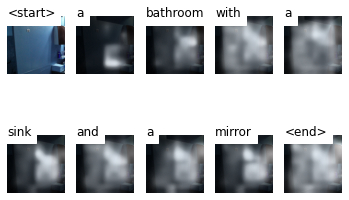

In [228]:
"""
Visualizes caption with weights at every word.

Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb

:param image_path: path to image that has been captioned
:param seq: caption
:param alphas: weights
:param rev_word_map: reverse word mapping, i.e. ix2word
:param smooth: smooth weights?
"""
smooth=True
image = orig_frame
# image = Image.open(image_path).convert('RGB')
# image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

words = [rev_word_map[ind] for ind in seq]


for t in range(len(words)):
    if t > 50:
        break
    plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

    plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=12)
    plt.imshow(image)
    current_alpha = alphas[t, :]
    if smooth:
        alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
    else:
        alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
    if t == 0:
        plt.imshow(alpha, alpha=0)
    else:
        plt.imshow(alpha, alpha=0.8)
    plt.set_cmap(cm.Greys_r)
    plt.axis('off')
# plt.savefig(f'{file_path}_processed.png')
plt.show()


In [413]:
def show(img, delay=0, name='test'):
    cv2.imshow(name,img)
    cv2.waitKey(delay)
    cv2.destroyAllWindows()
    
def get3d(img):
    img = test[:, :, np.newaxis]
    img = np.concatenate([img, img, img], axis=2)
    return img

def add_alpha(img, alpha):
    # First create the image with alpha channel
    rgba = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)

    # Then assign the mask to the last channel of the image
    rgba[:, :, 3] = alpha
    return rgba

def alpha_gen(alpha,ratio=None):
    npalphas = np.array(alpha)
    mx = (npalphas).max()
    if ratio is None:
        ratio = 255/mx
    npalphas = npalphas*ratio
    img_alpha = np.clip(npalphas, a_min=0,a_max=255)
    img_alpha = cv2.resize(img_alpha,(400,400))
    
    print('ratio=',ratio)
    print(f"min={img_alpha.min()}, max={img_alpha.max()}")
    
    return img_alpha

def add_overlay(img1, img2, alpha):
    dst = cv2.addWeighted(img1, alpha, img2, 1-alpha, 0)
    return dst

In [418]:
img  = cv2.imread(file_path)
img  = cv2.resize(img,(400,400))

# show(img_alpha)
# show(img)

alpha = 1


for i in range(len(alphas)):
    img_alpha = alpha_gen(alphas[i], ratio=10000)
    # show(img_alpha)

    img[:,:,2]=img_alpha
    out = np.clip(img,a_min=0,a_max=255)
    show(out, delay=1000)

ratio= 10000
min=255.0, max=255.0
ratio= 10000
min=6.162461491619753e-14, max=255.0
ratio= 10000
min=9.795911911497646e-13, max=254.84860229492188
ratio= 10000
min=1.3980506205837906e-12, max=167.22714233398438
ratio= 10000
min=3.0382530259026597e-12, max=164.50965881347656
ratio= 10000
min=1.5551399144136946e-12, max=254.1033935546875
ratio= 10000
min=1.7877241570776747e-12, max=187.3107147216797
ratio= 10000
min=2.2688884191574e-12, max=208.68870544433594
ratio= 10000
min=2.6342034022824867e-12, max=234.23553466796875
ratio= 10000
min=2.8769794706284824e-12, max=128.93109130859375


In [123]:
if img is None:
    if file_path is not None:
        img = cv2.imread(file_path)
        orig_frame=img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

In [414]:
for i in range(1,5):
    img  = cv2.imread(file_path)
    
    test = get3d(img_alpha)

    img  = cv2.resize(img,(400,400))
    test = cv2.resize(test,(400,400))

    dst = cv2.addWeighted(img, alpha, img, 1-alpha, 0)

    show(dst)

In [ ]:
    
#     img1 = cv2.imread('bike.png')
#     img2 = cv2.imread('mirror.png')
    
#     img1 = img
#     img2 = test
#     # Read about the resize method parameters here: https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=resize#resize
#     img2_resized = cv2.resize(img2, (img1.shape[1], img1.shape[0]))


#     show(img+test)
#     show(img) 
#     show(rgba) 
#     alpha=0.6
    
#     dst = cv2.addWeighted(img1, 0.7, img2_resized, 0.3, 0)


In [307]:
import cv2
import numpy as np

img1 = cv2.imread('bike.png')
img2 = cv2.imread('mirror.png')

# Read about the resize method parameters here: https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=resize#resize
img2_resized = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
dst = cv2.addWeighted(img1, 0.7, img2_resized, 0.3, 0)

cv2.imshow('dst',dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [104]:
test.max()

17.148167

In [188]:
(img-test).mean()
(img).mean()
(test).mean()

1.3010719

## Learning to add the overlay with transparent Image

In [415]:
img = cv2.resize(img,(400,400))
alpha=0.3

img1 = img.copy()
img2 = img.copy()

cv2.rectangle(img1, (20, 25), (95, 85),(0, 0, 255), -1)
cv2.putText(img1, "Demo: alpha={}".format(alpha),(10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)
# apply the overlay

dst = add_overlay(img1, img2, alpha)

show(dst)

In [137]:
type(img)

numpy.ndarray

In [227]:
img  = cv2.imread(file_path)
img = cv2.resize(img,(400,400))
test = cv2.resize(test,(400,400))

out_array = np.clip((img/1)-(test), a_min = 0, a_max = 255) 
img = np.clip(img-(test/1), a_min = 0, a_max = 255) 

alpha=0.5

cv2.addWeighted(out_array, alpha, img, 1 - alpha, 0, img)
show(img)

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6uw63ony\opencv\modules\core\src\arithm.cpp:693: error: (-5:Bad argument) When the input arrays in add/subtract/multiply/divide functions have different types, the output array type must be explicitly specified in function 'cv::arithm_op'


In [172]:
(img-test/200).min()

-0.08449296

In [168]:
(test/12).max()

1.4290138

In [161]:
img.max()

255